# 1. Load datas

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats, special

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
datas = pd.read_csv('./processed_datas/processed_data_2020.csv', encoding='cp949')
datas.index.name = 'id'
datas.columns

Index(['Unnamed: 0', '공원최단거리', '도서관최단거리', '초등학교최단거리', '중학교최단거리', '고등학교최단거리',
       '지진옥외대피소최단거리', '응급실최단거리', '0.5km지하철', '1.0km지하철', '1.5km지하철', '1.0km병원',
       '2.5km병원', '0.1km버스정류장', '0.3km버스정류장', '0.5km버스정류장', '건물면적', '건물금액',
       '건물주용도', '동네명', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [3]:
datas.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 
        'station_0.5km', 'station_1.0km', 'station_1.5km', 
        'hospital_1.0km', 'hospital_2.5km', 
        'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 
        'house_area', 'PRICE', 'house_type', 'town_name', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23']
for i in ['Unnamed: 0', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']:
    datas.drop(columns = i, inplace = True)
    
fit_data = datas[ ['min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 'hospital_1.0km',
       'hospital_2.5km', 'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 'house_area',
       'PRICE', 'house_type', 'station_0.5km', 'station_1.0km',
       'station_1.5km', 'town_name']]

datas = fit_data

In [4]:
def show_heatmap(df, target_col='PRICE'):
    corr = df.corr()
    top_corr=df[corr.nlargest(40,target_col)[target_col].index].corr()
    figure, ax1 = plt.subplots(nrows=1, ncols=1)
    figure.set_size_inches(20,15)
    sns.heatmap(top_corr, annot=True, ax=ax1)

In [5]:
# Remove outliers
filt = datas['min_park'] < 2
datas = datas[filt]

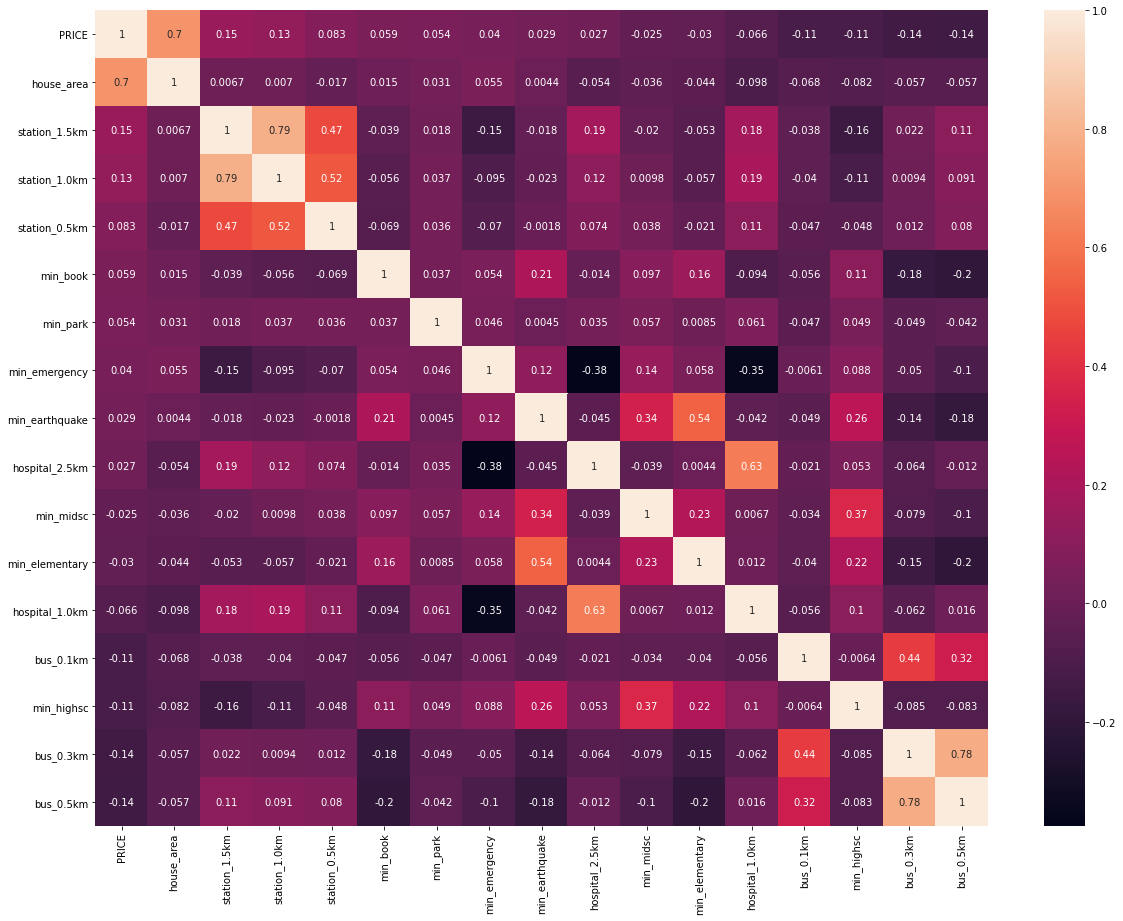

In [6]:
show_heatmap(datas)

### Skewness handling

In [7]:
def show_skewness(target_col, datas=datas):
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    figure.set_size_inches(21,7)
    sns.distplot(datas[target_col], fit=norm, ax=ax1)
    sns.distplot(np.log(datas[target_col]+1), fit=norm, ax=ax2)
    sns.distplot(stats.boxcox(datas[target_col]+0.0001)[0], fit=norm, ax=ax3)

    print(f"Original skew: {datas[target_col].skew()}")
    print(f"Log skew: {np.log(datas[target_col]+1).skew()}")
    print(f"Coxbox skew: {pd.Series(stats.boxcox(datas[target_col]+0.0001)[0]).skew()}")

In [8]:
lmbda = stats.boxcox(datas['PRICE']+0.0001)[1]

Original skew: 2.5979656243672316
Log skew: 0.08208657967371079
Coxbox skew: 0.005136254354772815


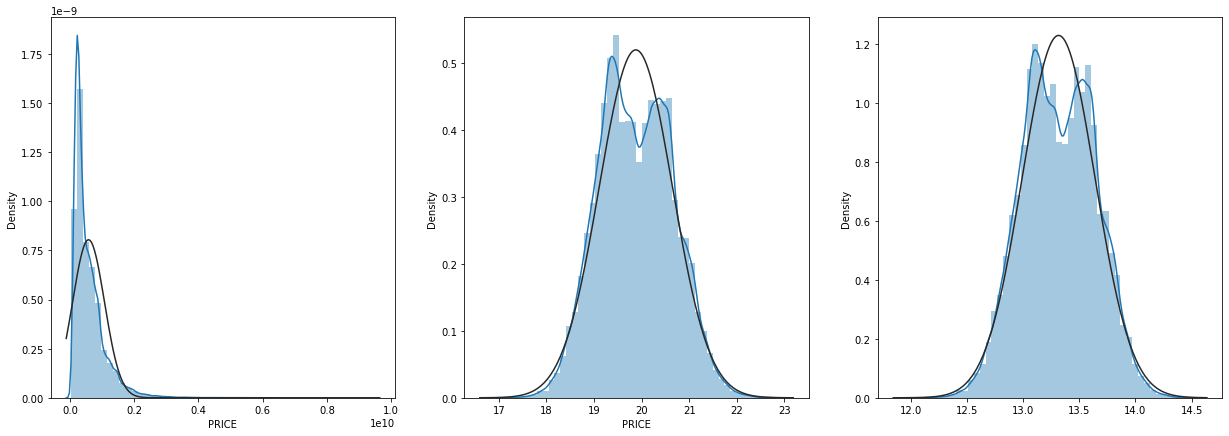

In [9]:
show_skewness('PRICE')

# 3. Preprocessing

## 3.1 Categorical Feature

In [10]:
Town = datas['town_name']

In [11]:
Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='광진구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)


In [12]:
datas['town_name'] = Town

In [13]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(datas['house_type'], prefix='house_type')
datas=pd.merge(datas, data_encoded, on='id')
datas=datas.drop(columns='house_type')

In [14]:
data_encoded=pd.get_dummies(datas['town_name'], prefix='town_name')
datas=pd.merge(datas, data_encoded, on='id')
datas=datas.drop(columns='town_name')

## 3.2 Numeric Feature

In [15]:
skew_fixed_datas = datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)

In [16]:
skew_fixed_datas['PRICE'], lmbda = stats.boxcox(datas['PRICE']+0.0001)

## 3.3 Train test split

In [17]:
X = skew_fixed_datas.drop(columns = ['PRICE'])
y = skew_fixed_datas['PRICE']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 77)

# 4. Training

In [18]:
# importing required libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

## Train by skew fixed features

In [19]:
model_RdmForest = RandomForestRegressor()
model_RdmForest.fit(Xtrain, Ytrain)
RdmForest_predictions=model_RdmForest.predict(Xtest)
train_RdmForest=model_RdmForest.predict(Xtrain)

In [20]:
boxcox_train_predictions = (train_RdmForest)
train_score=np.sqrt(mean_squared_error(Ytrain, boxcox_train_predictions))
train_score = special.inv_boxcox(train_score, lmbda)
print(f"Scoring with train data : {train_score}")

boxcox_predictions=(RdmForest_predictions)
predictions=special.inv_boxcox(boxcox_predictions, lmbda)

Scoring with train data : 1.0439159765534591


# 5. Test

In [21]:
X = datas.drop(columns = ['PRICE'])
y = datas['PRICE']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 77)

In [22]:
Ytest_list = Ytest.values
np.sqrt(mean_squared_error(Ytest_list, predictions))

98506692.58608657

In [23]:
# train 종류

boxcox_train_predictions = (train_RdmForest)
train_predictions=special.inv_boxcox(boxcox_train_predictions, lmbda)

Ytrain_list = Ytrain.values

np.sqrt(mean_squared_error(Ytrain_list, train_predictions))

64687914.02075476

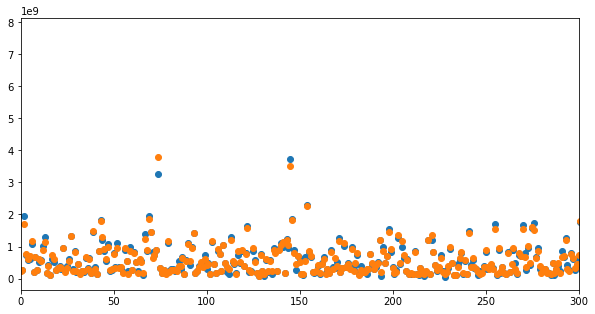

In [24]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 300)
plt.xlim(0, 300)
plt.scatter(np.arange(len(Ytest)), Ytest_list)
plt.scatter(np.arange(len(Ytest)), predictions)

# 6. Extract Results
# - 2021 Data

In [25]:
datas = pd.read_csv('./processed_datas/processed_data_2021.csv', encoding='cp949')
datas.index.name = 'id'

In [26]:
datas.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 'hospital_1.0km',
       'hospital_2.5km', 'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 'house_area',
       'PRICE', 'house_type', 'station_0.5km', 'station_1.0km',
       'station_1.5km', 'town_name']
datas.drop(columns = ['Unnamed: 0'], inplace = True)
datas = fit_data

In [27]:
Town = fit_data['town_name']

Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='광진구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)

fit_data['town_name'] = Town

In [28]:
Type = fit_data['house_type']

Type = Type.replace(to_replace='아파트', value=1)
Type = Type.replace(to_replace='연립주택', value=2)
Type = Type.replace(to_replace='오피스텔', value=3)

fit_data['house_type'] = Type

In [29]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(fit_data['house_type'], prefix='house_type')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='house_type')

In [30]:
data_encoded=pd.get_dummies(fit_data['town_name'], prefix='town_name')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='town_name')

In [31]:
except_y_datas = fit_data.drop(columns='PRICE')

skew_fixed_datas = except_y_datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)
# PRICE, lmbda = stats.boxcox(fit_datas['PRICE']+0.0001)

In [32]:
predictions = model_RdmForest.predict(skew_fixed_datas)

In [33]:
predictions=special.inv_boxcox(predictions, lmbda)

In [34]:
np.sqrt(mean_squared_error(fit_data['PRICE'],  predictions))

229395369.70462924

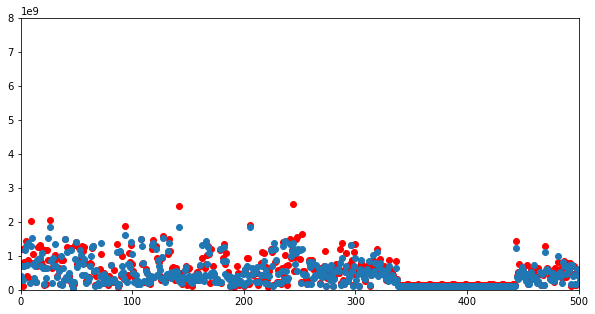

In [35]:
plt.figure(figsize=(10, 5))
plt.xlim(0,500)
plt.ylim(0, 8e9)
plt.scatter(np.arange(len(fit_data['PRICE'])), fit_data['PRICE'], color='red')
plt.scatter(np.arange(len(fit_data['PRICE'])), predictions)

# 6.2 Extract Results
# SM data

In [52]:
datas = pd.read_csv('./processed_datas/sm_data.csv', encoding='cp949')
datas.index.name = 'id'
datas.columns

Index(['Unnamed: 0', 'park_mindist', 'lib_mindist', 'elesch_mindist',
       'midsch_mindist', 'higsch_mindist', 'shell_mindist', 'emer_mindist',
       'hosp_1.0', 'hosp_2.5', 'bus_0.1', 'bus_0.3', 'bus_0.5', 'build_size',
       'build_price', 'build_kind', 'subway_0.5', 'subway_1.0', 'subway_1.5',
       'guindex', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

In [53]:
datas.columns = ['Unnamed: 0', 'min_park', 'min_book', 'min_elementary', 'min_midsc',
       'min_highsc', 'min_earthquake', 'min_emergency', 
        'hospital_1.0km', 'hospital_2.5km', 
        'bus_0.1km', 'bus_0.3km', 'bus_0.5km', 
        'house_area', 'PRICE','house_type',
        'station_0.5km', 'station_1.0km', 'station_1.5km', 
        'town_name', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']

fit_data = datas[['min_park', 'min_book', 'min_elementary', 'min_midsc', 'min_highsc',
       'min_earthquake', 'min_emergency', 'hospital_1.0km', 'hospital_2.5km', 'bus_0.1km',
       'bus_0.3km', 'bus_0.5km', 'house_area', 'PRICE', 'house_type',
        'station_0.5km', 'station_1.0km', 'station_1.5km',
         'town_name']]

In [54]:
fit_data.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000


In [55]:
Town = fit_data['town_name']

Town = Town.replace(to_replace='강남구', value=1)
Town = Town.replace(to_replace='서초구', value=1)

Town = Town.replace(to_replace='강동구', value=2)
Town = Town.replace(to_replace='광진구', value=2)
Town = Town.replace(to_replace='동작구', value=2)
Town = Town.replace(to_replace='마포구', value=2)
Town = Town.replace(to_replace='성동구', value=2)
Town = Town.replace(to_replace='송파구', value=2)
Town = Town.replace(to_replace='용산구', value=2)
Town = Town.replace(to_replace='종로구', value=2)
Town = Town.replace(to_replace='중구', value=2)

Town = Town.replace(to_replace='강북구', value=3)
Town = Town.replace(to_replace='강서구', value=3)
Town = Town.replace(to_replace='관악구', value=3)
Town = Town.replace(to_replace='광진구', value=3)
Town = Town.replace(to_replace='구로구', value=3)
Town = Town.replace(to_replace='금천구', value=3)
Town = Town.replace(to_replace='노원구', value=3)
Town = Town.replace(to_replace='도봉구', value=3)
Town = Town.replace(to_replace='동대문구', value=3)
Town = Town.replace(to_replace='서대문구', value=3)
Town = Town.replace(to_replace='성북구', value=3)
Town = Town.replace(to_replace='양천구', value=3)
Town = Town.replace(to_replace='영등포구', value=3)
Town = Town.replace(to_replace='은평구', value=3)
Town = Town.replace(to_replace='중랑구', value=3)

fit_data['town_name'] = Town

In [56]:
Type = fit_data['house_type']

Type = Type.replace(to_replace='-1', value=1)
Type = Type.replace(to_replace='0', value=2)
Type = Type.replace(to_replace='1', value=3)

fit_data['house_type'] = Type

In [57]:
fit_data.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km,town_name
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234,2.284194
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859,0.706041
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000,3.000000


In [58]:
filt = fit_data['bus_0.5km'] == -1
fit_data[filt]['bus_0.5km'] = 0
fit_data.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,bus_0.3km,bus_0.5km,house_area,PRICE,house_type,station_0.5km,station_1.0km,station_1.5km,town_name
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,1.224690e+05,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,1.008400,0.233807,0.373093,0.506394,0.685183,0.265079,1.407665,5.962227,29.103471,0.886869,8.067233,21.172256,53.585133,5.639462e+08,-0.110207,0.635598,1.578661,2.359234,2.284194
std,0.512219,0.141951,0.186046,0.258802,0.389402,0.159776,0.776906,4.727687,14.263987,1.275341,4.613001,9.225915,29.406261,6.047414e+08,0.911944,0.754078,1.061703,1.346859,0.706041
min,0.003000,0.000000,0.003000,0.009000,0.004000,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,6.280000,2.500000e+07,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.634000,0.134000,0.238000,0.311000,0.388000,0.159000,0.830000,2.000000,20.000000,0.000000,5.000000,15.000000,30.460000,2.200000e+08,-1.000000,0.000000,1.000000,2.000000,2.000000
50%,0.938000,0.211000,0.359000,0.483000,0.625000,0.236000,1.310000,5.000000,28.000000,0.000000,8.000000,20.000000,48.410000,3.370000e+08,0.000000,0.000000,1.000000,2.000000,2.000000
75%,1.309000,0.302000,0.478000,0.655000,0.906000,0.339000,1.854000,9.000000,36.000000,2.000000,11.000000,27.000000,64.530000,7.050000e+08,1.000000,1.000000,2.000000,3.000000,3.000000
max,3.234000,1.427000,1.923000,2.305000,4.203000,2.169000,5.696000,32.000000,113.000000,9.000000,32.000000,66.000000,489.790000,2.450000e+10,1.000000,5.000000,7.000000,8.000000,3.000000


In [59]:
# 원핫 인코딩 한다
data_encoded=pd.get_dummies(fit_data['house_type'], prefix='house_type')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='house_type')

In [60]:
data_encoded=pd.get_dummies(fit_data['town_name'], prefix='town_name')
fit_data=pd.merge(fit_data, data_encoded, on='id')
fit_data=fit_data.drop(columns='town_name')

In [61]:
except_y_datas = fit_data.drop(columns='PRICE')
skew_fixed_datas = except_y_datas.apply(lambda col: stats.boxcox(col+0.0001)[0], axis=0)

In [62]:
skew_fixed_datas.describe()

,min_park,min_book,min_elementary,min_midsc,min_highsc,min_earthquake,min_emergency,hospital_1.0km,hospital_2.5km,bus_0.1km,...,house_area,station_0.5km,station_1.0km,station_1.5km,house_type_-1,house_type_0,house_type_1,town_name_1,town_name_2,town_name_3
count,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,...,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000,122469.000000
mean,-0.068374,-1.170131,-0.823506,-0.635925,-0.441170,-1.163924,0.266489,2.071617,7.588283,-8.079287,...,3.939698,-4.650845,0.287491,0.965611,-5.548603,-687.017035,-15.073988,-969.921229,-8.986794,-8.149236
std,0.517474,0.341406,0.310716,0.378831,0.500490,0.377576,0.651376,2.009512,2.197660,7.472163,...,0.539899,4.812032,1.031410,0.949588,5.299032,295.611690,11.472673,403.497636,7.659217,7.103115
min,-2.138132,-2.477823,-1.930985,-1.901938,-2.285582,-2.759264,-2.006401,-2.387905,-2.193102,-14.522769,...,1.857553,-9.435942,-2.016487,-1.804094,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
25%,-0.413862,-1.389564,-1.032729,-0.899916,-0.793305,-1.403311,-0.178742,0.801478,6.317929,-14.522769,...,3.486580,-9.435942,0.000100,0.844122,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
50%,-0.063032,-1.163938,-0.806502,-0.616763,-0.429825,-1.165132,0.286913,2.277582,7.710635,-14.522769,...,3.970358,-9.435942,0.000100,0.844122,-10.609157,-814.212636,-23.805604,-1137.779186,-15.514426,-14.340394
75%,0.285490,-0.954996,-0.619947,-0.383791,-0.096759,-0.919674,0.709999,3.561182,8.896980,0.671469,...,4.271830,0.000100,0.825619,1.509640,0.000100,-814.212636,0.000100,-1137.779186,0.000100,0.000100
max,1.525112,0.381680,0.769992,1.021513,1.916739,0.874528,2.620538,7.646529,16.358399,1.988598,...,6.427171,1.602698,3.256489,3.891878,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100


In [63]:
predictions = model_RdmForest.predict(skew_fixed_datas)

In [64]:
predictions=special.inv_boxcox(predictions, lmbda)

In [65]:
np.sqrt(mean_squared_error(fit_data['PRICE'],  predictions))

728200220.0687464

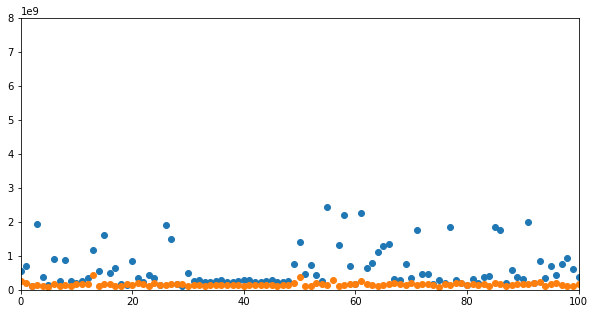

In [66]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 100)
plt.ylim(0, 8e9)
plt.scatter(np.arange(len(fit_data['PRICE'])), fit_data['PRICE'])
plt.scatter(np.arange(len(fit_data['PRICE'])), predictions)